In [1]:
import numpy as np
import pandas as pd
import os
from scipy import optimize
from scipy.special import logsumexp
from tqdm.auto import tqdm
import pymc3 as pm
import theano
import theano.tensor as T

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
dataDir = "individual_participant_data/"
subLists = sorted(os.listdir(dataDir))

header_names = ['trial_num', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'stage_1_response', 
                'stage_1_stimulus', 'stage_1_rt', 'transition', 'stage_2_response', 'stage_2_stimulus',
                'stage_2_state', 'stage_2_rt', 'reward', 'redundant_task_var']

In [3]:
def update_Q(a1, a2, s, r, Q_stage2, Q_MB, Q_MF0, Q_MF1, I, alpha):
    """
    Function to update the Q's and I after each trial.
    
    Inputs:
    a1 - choice made at stage 1
    a2 - choice made at stage 2
    s - second stage state
    r - reward
    "other input arguments as named"
    
    Returns:
    Updated Q's and I
    
    """
    
    # Stage 2 Q table --------------------------------------------------------------
    Q_stage2 = T.set_subtensor(Q_stage2[s, a2], (1-alpha)*Q_stage2[s, a2] + r)
    
    # Even though we do not have data for these we apply the discounted reward on Q tables assuming 
    # factors of (1-alpha) is w.r.t time not observation
    Q_stage2 = T.set_subtensor(Q_stage2[s, 1-a2], (1-alpha)*Q_stage2[s, 1-a2])
    Q_stage2 = T.set_subtensor(Q_stage2[1-s, a2], (1-alpha)*Q_stage2[1-s, a2])
    Q_stage2 = T.set_subtensor(Q_stage2[1-s, 1-a2], (1-alpha)*Q_stage2[1-s, 1-a2])
    
    
    # Stage 1 Q table --------------------------------------------------------------
    # Since state stage2 = 0 is predominant state corresponding to choice stage1 = 0 and vice-versa
    Q_MB = T.set_subtensor(Q_MB[a1], T.max(Q_stage2[a1, :]))
    Q_MB = T.set_subtensor(Q_MB[1-a1], T.max(Q_stage2[1-a1, :]))
    
    Q_MF0 = T.set_subtensor(Q_MF0[a1], (1-alpha)*Q_MF0[a1] + Q_stage2[s, a2])
    Q_MF0 = T.set_subtensor(Q_MF0[1-a1], (1-alpha)*Q_MF0[1-a1])
    
    Q_MF1 = T.set_subtensor(Q_MF1[a1], (1-alpha)*Q_MF1[a1] + r)
    Q_MF1 = T.set_subtensor(Q_MF1[1-a1], (1-alpha)*Q_MF1[1-a1])
    
    # Binary indicator for the choice that repeats the one made on the previous trial
    I = T.set_subtensor(I[a1], 1)
    I = T.set_subtensor(I[1-a1], 0)
    
    return [Q_stage2, Q_MB, Q_MF0, Q_MF1, I]

def likelihood_logp(x, observed_data):
    alpha, beta_stage2, beta_MB, beta_MF0, beta_MF1, beta_stick = x
    actions_1 = theano.shared(np.asarray(observed_data[0], dtype='int32'))
    actions_2 = theano.shared(np.asarray(observed_data[1], dtype='int32'))
    states_2 = theano.shared(np.asarray(observed_data[2], dtype='int32'))
    rewards = theano.shared(np.asarray(observed_data[3], dtype='int32'))
    
    Q_stage2 = T.zeros((2, 2), dtype='float32')
    Q_MB = T.zeros(2, dtype='float32')
    Q_MF0 = T.zeros(2, dtype='float32')
    Q_MF1 = T.zeros(2, dtype='float32')
    I = T.zeros(2, dtype='float32')

    [Q_stage2, Q_MB, Q_MF0, Q_MF1, I], _ = theano.scan(fn=update_Q,
                                                       sequences=[actions_1, actions_2, states_2, rewards],
                                                       outputs_info=[Q_stage2, Q_MB, Q_MF0, Q_MF1, I],
                                                       non_sequences=[alpha])
    
    # likelihood_logp from stage 2
    rv_stage2 = Q_stage2*beta_stage2
    log_prob_stage2 = rv_stage2 - pm.math.logsumexp(rv_stage2, axis=-1)
    log_prob_stage2 = log_prob_stage2[T.arange(actions_2.shape[0]-1), states_2[1:], actions_2[1:]]
    logp_stage2 = T.sum(log_prob_stage2)

    # likelihood_logp from stage 1
    rv_stage1 = beta_MB*Q_MB + beta_MF0*Q_MF0 + beta_MF1*Q_MF1 + beta_stick*I
    log_prob_stage1 = rv_stage1 - pm.math.logsumexp(rv_stage1, axis=-1)
    log_prob_stage1 = log_prob_stage1[T.arange(actions_1.shape[0]-1), actions_1[1:]]
    logp_stage1 = T.sum(log_prob_stage1)
    
    # Note this assumes that both the choices are i.i.d.
    # Thus, the probability distribution will be a simple product
    # Hence, summation of logp
    logp_Total = logp_stage1 + logp_stage2
    
    return logp_Total

In [4]:
# Perform only for one subject

subName = subLists[0]

f = open(dataDir+subName, "r")
num_row_skip = 0
while True:
    num_row_skip += 1
    txt = f.readline()
    if (len(txt.split(","))>3) and (txt.split(",")[2] == "twostep_instruct_9"):
        break

# read data after 'twostep_instruct_9'
data = pd.read_csv(dataDir+subName, skiprows=num_row_skip, index_col=0, names=header_names)

# data formatting
data = data.drop(columns=['drift_1', 'drift_2', 'drift_3', 'drift_4', 'stage_1_stimulus', 'stage_1_rt', 'transition', 'stage_2_stimulus', 'stage_2_rt', 'redundant_task_var'])
data = data.replace(['left'], 0)
data = data.replace(['right'], 1)
data['stage_2_state'] = data['stage_2_state'].replace([2], 0)
data['stage_2_state'] = data['stage_2_state'].replace([3], 1)

# Minimise the negative log likelihood function to get the parameters
x0 = list(np.random.rand(6)) # Random initialisation
bounds = [(0, 1)] + [(0, np.inf)]*5 # Limit alpha from 0 to 1 and beta for only positive values

actions_1 = data['stage_1_response'].values
actions_2 = data['stage_2_response'].values
states_2 = data['stage_2_state'].values
rewards = data['reward'].values

In [6]:
model = pm.Model()

with model:
    alpha = pm.Beta('alpha', 1, 1)
    beta_stage2 = pm.HalfNormal('beta_stage2', 20)
    beta_MB = pm.HalfNormal('beta_MB', 20)
    beta_MF0 = pm.HalfNormal('beta_MF0', 20)
    beta_MF1 = pm.HalfNormal('beta_MF1', 20)
    beta_stick = pm.HalfNormal('beta_stick', 20)
    
    x = [alpha, beta_stage2, beta_MB, beta_MF0, beta_MF1, beta_stick]
    observed_data = [actions_1, actions_2, states_2, rewards]
    likelihood = pm.Potential('likelihood', likelihood_logp(x, observed_data))

    trace = pm.sample(chains=4, return_inferencedata=True, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [beta_stick, beta_MF1, beta_MF0, beta_MB, beta_stage2, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 723 seconds.


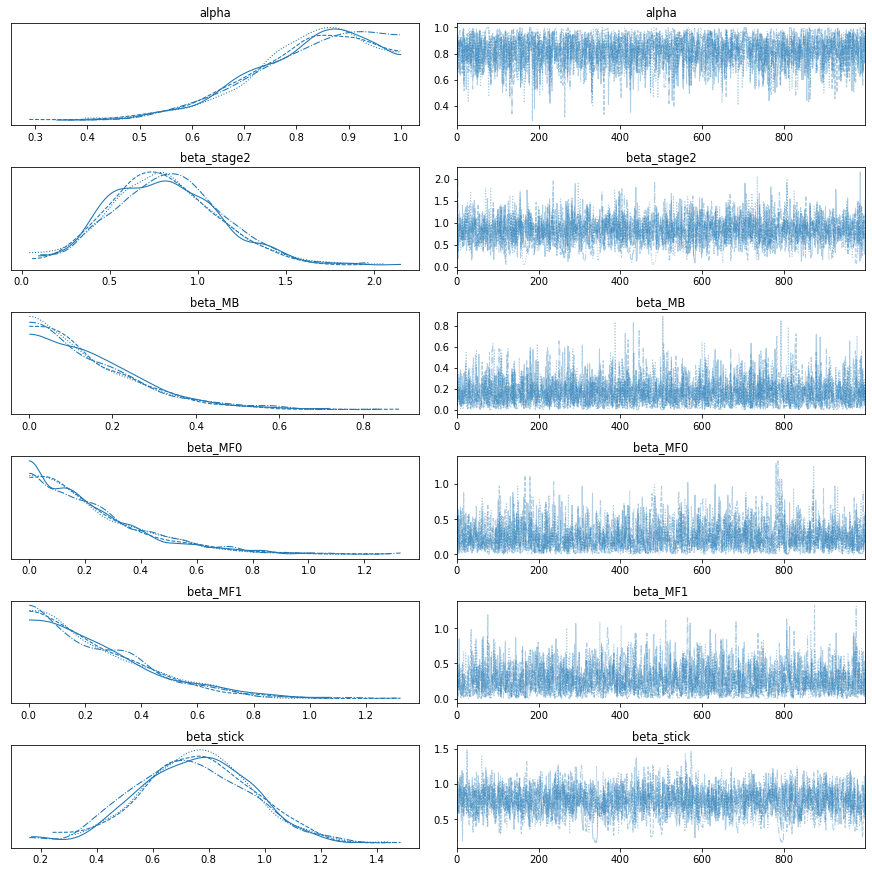

In [7]:
with model:
    az.plot_trace(trace)
    plt.show()

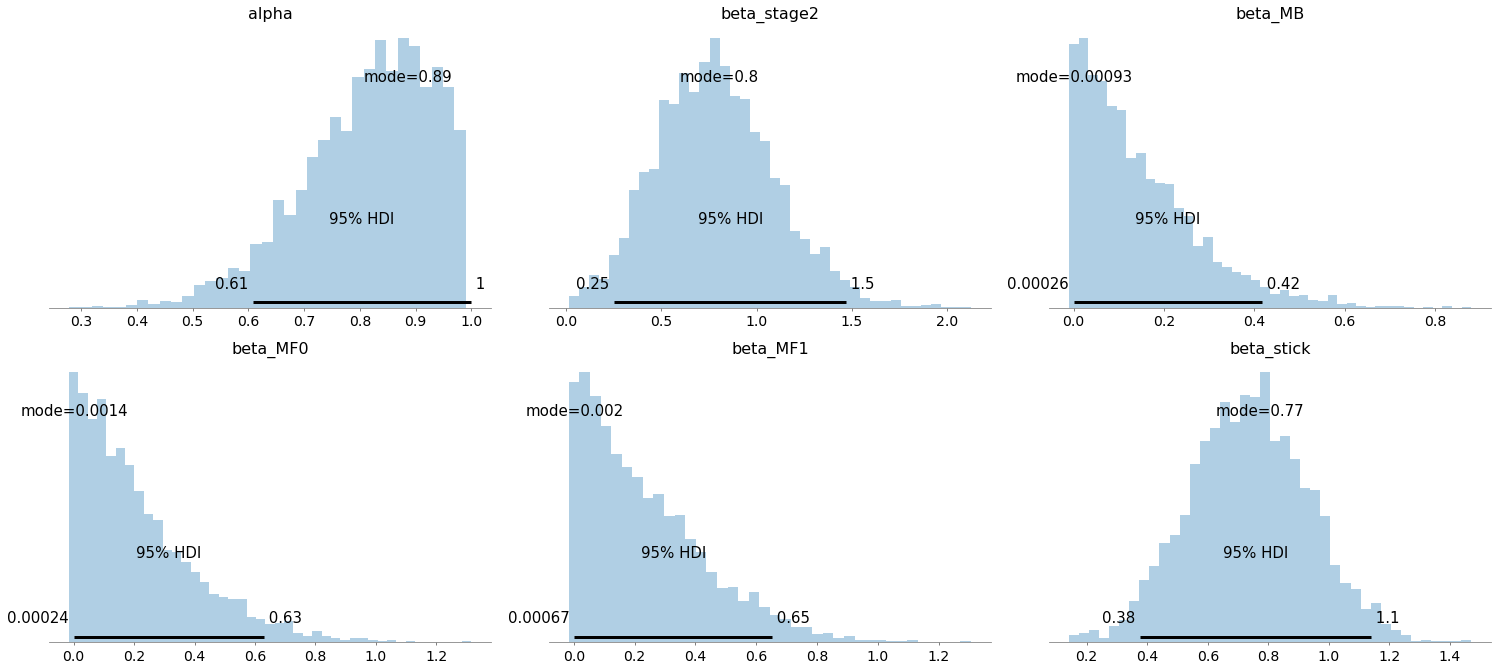

In [8]:
with model:
    az.plot_posterior(trace, hdi_prob=.95, kind='hist', point_estimate='mode')
    plt.show()